### DNA


In [1]:
import requests
import numpy as np
from sklearn.datasets import load_svmlight_file
import os
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torcheval import metrics
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

h:\Uni\WiSe 2024\ML LAB\ml_lab_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_features = 180
n_classes = 3
batch_size = 32

In [3]:
urls_dict = {"train":"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/dna.scale.tr",
                "val":"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/dna.scale.val",
                "test":"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/dna.scale.t"}

class dna_dataset(Dataset):
    def obtain_dataset(slef, split_name, url):
        location = "../../data/dna/dna"
        # download the dataset
        file_path = f"{location}_{split_name}_raw"
        with open(file_path, 'w') as f:
            r = requests.get(url)
            f.writelines(r.content.decode("utf-8"))
        x, y  = load_svmlight_file(file_path, n_features=n_features)
        x = np.asarray(x.todense(), dtype=np.float32)
        y = y.reshape(-1, 1).astype(np.float32)
        # pre-process the labels
        encoder = OneHotEncoder(sparse_output=False)
        y = encoder.fit_transform(y)
        return x, y

    def __init__(self, split_name, url) -> None:
        super().__init__()
        self.x, self.y = self.obtain_dataset(split_name, url)
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



In [4]:
# define the datasets
train_dataset = dna_dataset("train", urls_dict["train"])
val_dataset = dna_dataset("val", urls_dict["val"])
test_dataset = dna_dataset("test", urls_dict["test"])
# define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f"dense_0", nn.Linear(n_features, n_features//5))
        self.layers.add_module(f"activation_0", nn.ReLU())
        self.layers.add_module(f"dense_1", nn.Linear(n_features//5, n_features//10))
        self.layers.add_module(f"activation_1", nn.ReLU())
        self.layers.add_module(f"dense_2", nn.Linear(n_features//10, n_classes))
        self.layers.add_module(f"activation_2", nn.Softmax())
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=0.01)
        self.metric = metrics.MulticlassAccuracy(num_classes=n_classes)
    
    def forward(self, x):
        return self.layers(x)
    
    def calculate_accuracy(self, y_pred, y_true):
        self.metric.update(y_pred, torch.argmax(y_true, dim=1))

        # compute the metric
        accuracy = self.metric.compute()

        return accuracy


h:\Uni\WiSe 2024\ML LAB\ml_lab_venv\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [10/100], Loss: 0.6161
Epoch [20/100], Loss: 0.6038
Epoch [30/100], Loss: 0.6009
Epoch [40/100], Loss: 0.5996
Epoch [50/100], Loss: 0.5988
Epoch [60/100], Loss: 0.5984
Epoch [70/100], Loss: 0.5980
Epoch [80/100], Loss: 0.5978
Epoch [90/100], Loss: 0.5976
Epoch [100/100], Loss: 0.5974


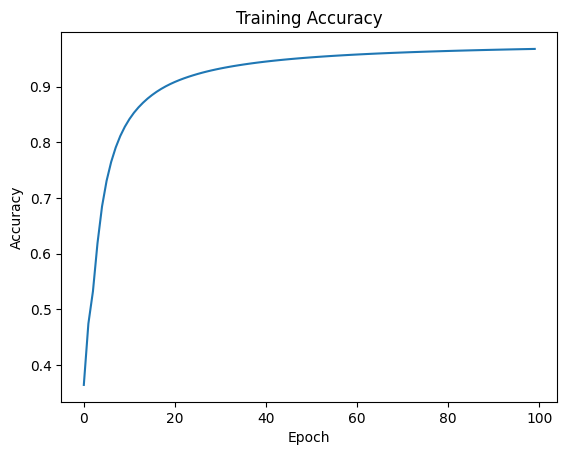

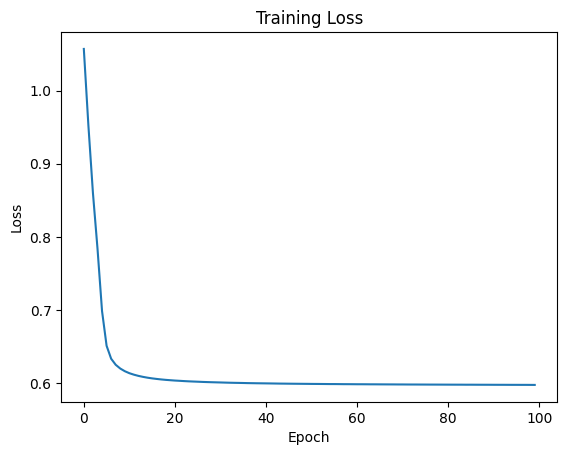

In [6]:



num_epochs = 100

# Create an instance of the neural network
model = NeuralNetwork()

# Lists to store the loss values
loss_values = []
accuracy_values = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    total_accuracy = 0
    # Iterate over the training dataset
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = model.criterion(outputs, torch.argmax(labels, dim=1))
        
        # Backward pass and optimization
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += model.calculate_accuracy(outputs, labels)
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    accuracy_values.append(avg_accuracy)
    loss_values.append(avg_loss)
    
    # Print the loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot the accuracy values
plt.plot(accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


### 2 Moons

In [16]:
import requests
import numpy as np
from sklearn.datasets import load_svmlight_file
import os
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torcheval import metrics
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
n_features = 2
n_classes = 2
batch_size = 32

class TwoMoonsDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        current_file_path = os.getcwd()
        data_path = os.path.join(os.path.dirname(current_file_path), "..", "data", "twomoons", "TwoMoonsDF.xlsx")
        data_path = os.path.normpath(data_path)
        df = pd.read_excel(data_path)
        df_Y = df['Label']
        df_X = df.drop('Label', axis=1)
        self.x = df_X.values.astype(np.float32)
        self.y = df_Y.values.astype(np.float32).reshape(-1, 1)
        print(self.x.shape)
        print(self.y.shape)

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, idx: int) -> tuple:
        return self.x[idx], self.y[idx]


In [46]:

# define the datasets
dataset = TwoMoonsDataset()


(3000, 2)
(3000, 1)


In [41]:


# Assuming you have a dataset called 'dataset'

# Define the sizes of train, test, and validation sets
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = int(0.2 * len(dataset))   # 20% for testing
val_size = len(dataset) - train_size - test_size  # Remaining for validation

# Split the dataset into train, test, and validation sets
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Print the sizes of the resulting datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2100
Test dataset size: 600
Validation dataset size: 300


In [42]:

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f"dense_0", nn.Linear(n_features, 128))
        self.layers.add_module(f"activation_0", nn.ReLU())
        self.layers.add_module(f"dense_1", nn.Linear(128, 128))
        self.layers.add_module(f"activation_1", nn.ReLU())
        self.layers.add_module(f"dense_2", nn.Linear(128, n_classes))
        self.layers.add_module(f"activation_2", nn.Softmax())
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=0.01)
        self.metric = metrics.MulticlassAccuracy(num_classes=n_classes)
    
    def forward(self, x):
        return self.layers(x)
    
    def calculate_accuracy(self, y_pred, y_true):
        self.metric.update(y_pred, y_true)

        # compute the metric
        accuracy = self.metric.compute()

        return accuracy


In [43]:

# Create the train loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the validation loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:




num_epochs = 100

# Create an instance of the neural network
model = NeuralNetwork()

# Lists to store the loss values
loss_values = []
accuracy_values = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    total_accuracy = 0
    # Iterate over the training dataset
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = model.criterion(outputs, labels)
        
        # Backward pass and optimization
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += model.calculate_accuracy(outputs, labels)
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    accuracy_values.append(avg_accuracy)
    loss_values.append(avg_loss)
    
    # Print the loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot the accuracy values
plt.plot(accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


h:\Uni\WiSe 2024\ML LAB\ml_lab_venv\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


RuntimeError: 0D or 1D target tensor expected, multi-target not supported